In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

# Global parameters

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed 
}
params['epsilon']=0.1
params['sigma']=0.01


In [3]:

# analysis (parameters for faster computing during testing!) 
params['epsilon']=0.2
params['sigma']=0.1
params['window']=1
# for testing purposes!
list_lambda = 1 - 10 ** np.linspace(-1, -4, 4)
print(list_lambda)

[0.9    0.99   0.999  0.9999]


## Full analysis

Attention: not paralleized yet ...

In [4]:
result = analysis_beta_approximation(params, list_lambda, 'simulations.db', verbose=True, redo=True)

Load beta interpolation from file: ./dat/beta_interpolation_seed=1001.pkl
Using h_range = (3.162277660168379e-07, 10.0)


100%|██████████| 4/4 [01:25<00:00, 21.31s/it]


## Step-by-step for comparison

In [5]:
# load relevant information from database
import sqlite3
con = sqlite3.connect('./simulations.db')
cur = con.cursor()

# load the path of the function approximation
beta_interpolation = pd.read_sql_query(f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}", con)
# if there is no such function approximation, raise error
if len(beta_interpolation)==0:
    raise ValueError(f"No function approximation in database for params")
# if there is more than one such function approximation, raise error
if len(beta_interpolation)>1:
    raise ValueError(f"Multiple function approximations in database for params")
# load the path of the simulation
file_beta_interpolation = beta_interpolation['filename'].values[0]
print(file_beta_interpolation)

# load the function approximation
import torch
from torch import nn
beta_approx = FunctionApproximation(filename=file_beta_interpolation)

./dat/beta_interpolation_seed=1001.pkl


### Check that approximation yields distributed result around theoretical mean

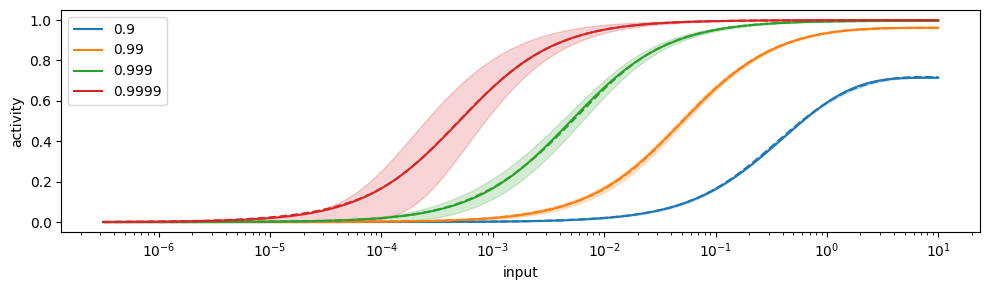

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 200)
for i, lam in enumerate(list_lambda):
    # theory
    ref = axes.plot(hs, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam))
    # simulation approximation with variance!
    avals, bvals = beta_approx(lam*np.ones_like(hs), params['window']*np.ones_like(hs), hs)
    mean = avals/(avals+bvals)
    # calculate percentiles from stats.beta(a,b)
    beta = stats.beta(avals, bvals)
    percentile_25 = beta.ppf(0.25)
    percentile_50 = beta.ppf(0.5)
    percentile_75 = beta.ppf(0.75)
    axes.plot(hs, mean, color=ref[0].get_color(), linestyle='--')
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
axes.legend()
plt.tight_layout()
plt.show()

### Convolution of beta distribution with Guassian 

In [7]:
N = beta_approx.params['N']
delta = 1/N
support = np.arange(0, 1+4*params['sigma'], delta)
support = np.concatenate((-support[::-1], support[1:]))

loc = beta_approx.params["loc"]
scale = beta_approx.params["scale"]

def ml_pmf(window, lam, h, verbose=False):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(support, a, b, loc=loc, scale=scale))
    # convolution with a Gaussian distribution at every point of the support
    pmf_norm = stats.norm.pdf(support, 0, params['sigma'])*delta
    return np.convolve(pmf_beta, pmf_norm, mode="same")

100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


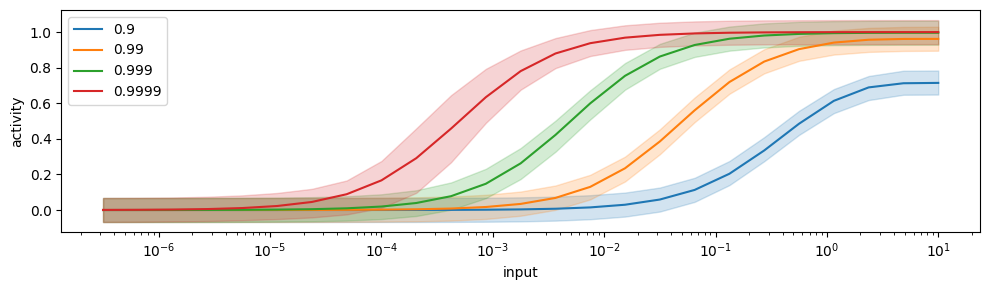

In [8]:
# replot previous plot with convolution
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 25)
for i, lam in enumerate(list_lambda):
    # theory
    ref = axes.plot(hs, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam))
    percentile_25 = np.zeros_like(hs)
    percentile_50 = np.zeros_like(hs)
    percentile_75 = np.zeros_like(hs)
    for (i,h) in tqdm(enumerate(hs), total=len(hs)):
        pmf = ml_pmf(params['window'], lam, h)
        percentile_25[i] = support[np.searchsorted(np.cumsum(pmf), 0.25)]
        percentile_50[i] = support[np.searchsorted(np.cumsum(pmf), 0.5)]
        percentile_75[i] = support[np.searchsorted(np.cumsum(pmf), 0.75)]
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
axes.legend()
plt.tight_layout()
plt.show()



In [9]:
h_range = beta_approx.input_range[beta_approx.input_names.index("h")]

# define function for dask
def analyse(lam):
    def pmf_o_given_h(h):
        return ml_pmf(params['window'], lam, h)

    pmf_ref_left = stats.norm.pdf(support, mean_field_activity(lam, params['mu'], 0), params['sigma']) * delta
    pmf_ref_right = stats.norm.pdf(support, mean_field_activity(lam, params['mu'], 1e3), params['sigma']) * delta
    hs_left = find_discriminable_inputs(
        pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], params['epsilon']
    )
    hs_right = find_discriminable_inputs(
        pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], params['epsilon'], start="right"
    )
    if len(hs_left) > 0 and len(hs_right) > 0:
        return lam, 0.5 * (len(hs_left) + len(hs_right)), dynamic_range((hs_left[0], hs_right[0]))
    else:
        return lam, np.nan, np.nan


In [10]:
# parallize over lambdas with dask
from dask.distributed import Client, LocalCluster, as_completed
cluster = LocalCluster()
dask_client = Client(cluster)

futures = dask_client.map(analyse, list_lambda)

# run analysis
data = []
for future in tqdm(as_completed(futures), total=len(list_lambda)):
    data.append(future.result())

print(data)

# sort data by first column
data = np.array(sorted(data, key=lambda x: x[0]))

/Users/johannes/miniforge3/envs/finite-observation/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61100 instead
  warnings.warn(
100%|██████████| 4/4 [01:26<00:00, 21.61s/it]

[(0.9999, 2.0, 9.302383202502774), (0.9, 3.0, 8.68058670310132), (0.999, 4.0, 13.087746061076293), (0.99, 4.0, 12.796479742697095)]


In [11]:
# compare data and result['data']) line by line
for d1,d2 in zip(result['data'], data):
    print(d1==d2, d1,d2)



[ True  True  True] [0.9       3.        8.6805867] [0.9       3.        8.6805867]
[ True  True  True] [ 0.99        4.         12.79647974] [ 0.99        4.         12.79647974]
[ True  True  True] [ 0.999       4.         13.08774606] [ 0.999       4.         13.08774606]
[ True  True  True] [0.9999    2.        9.3023832] [0.9999    2.        9.3023832]


## Additional plots to check analysis

In [12]:
# stop notebook here
import sys
sys.exit()

SystemExit: 

/Users/johannes/miniforge3/envs/finite-observation/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


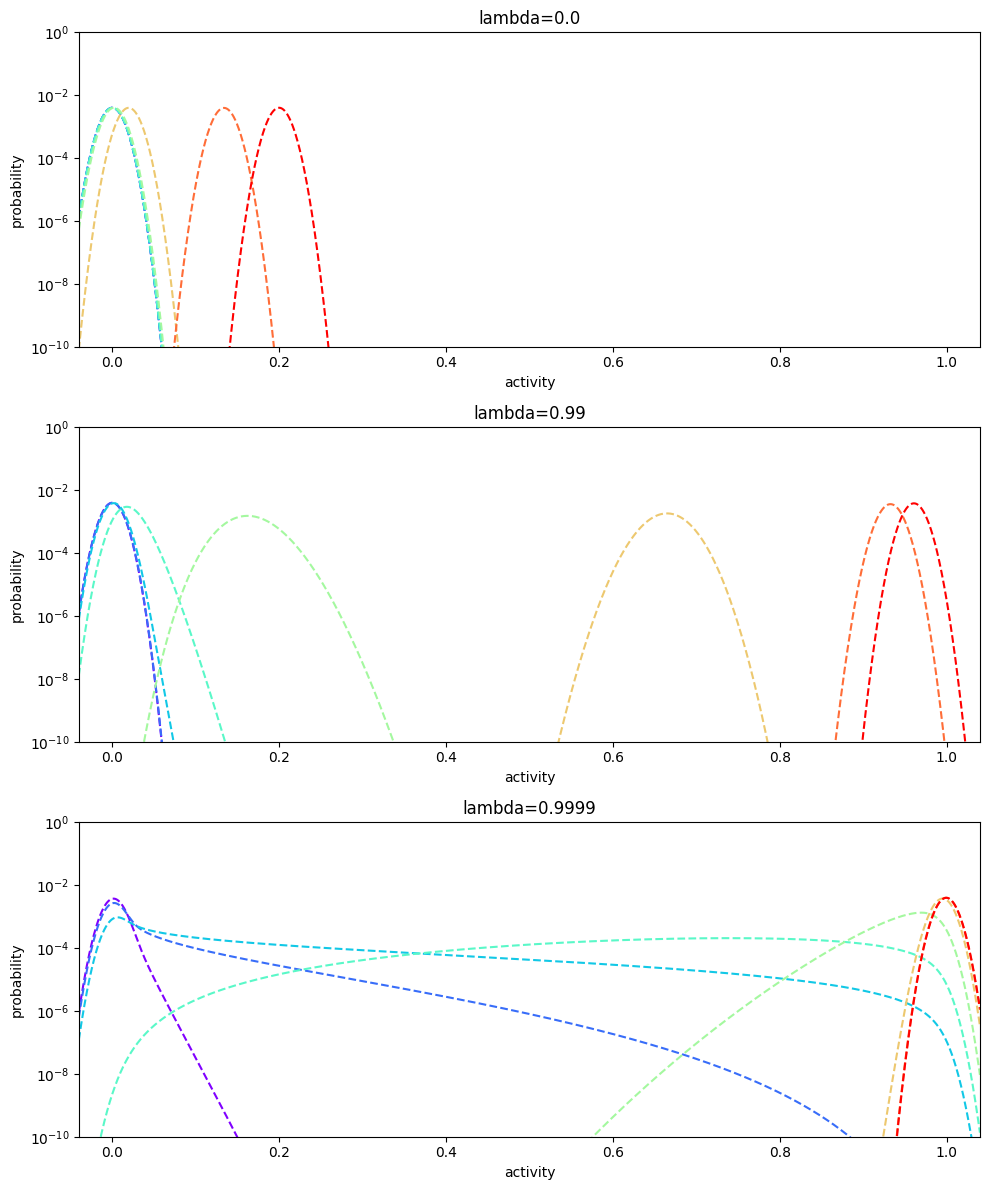

In [ ]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.99, 0.9999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-6, 1, 8)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        c = next(color)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.1323512989230912, 0.27845940744987974, 0.4473609720528709, 0.6564086914935261, 0.9370948606043044, 1.3655744452527596]
hs_right:  [1.9272217221554335, 1.2320579060344925, 0.8547079581041453, 0.5970923817248918, 0.400633383526061, 0.23899600011564212]


(-0.04, 1.04)

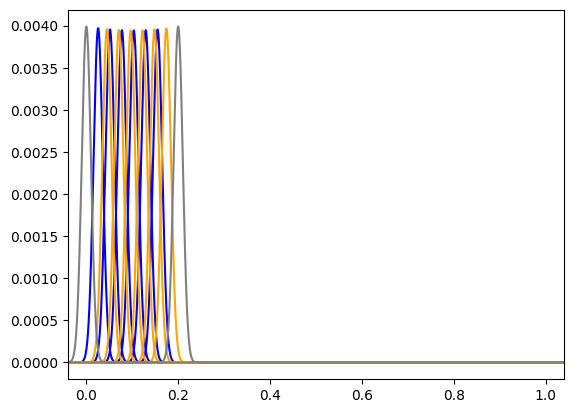

In [ ]:
# test discriminable intervals
lam = 0.0
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! 
h_range=[10**-7,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above and needs to be consistent with the ml_pmf function!
print(a_inf(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

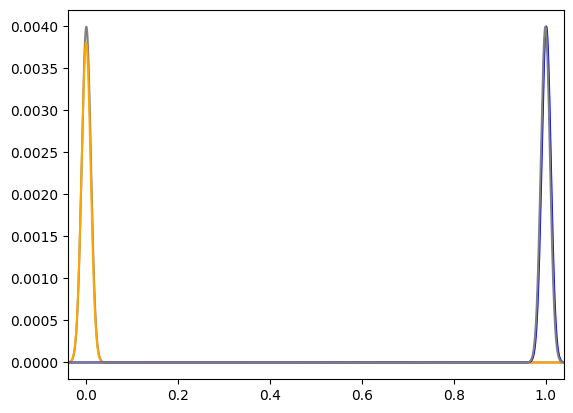

hs from left
possible solution: h=0.00014642244268902262 with overlap to end of 0.00036131173848048966 ... accepted
possible solution: h=0.0014391328045296468 with overlap to end of 0.009653638781501717 ... accepted
possible solution: h=0.010411023009432 with overlap to end of 0.11969698048953048 ... rejected
hs from right
possible solution: h=0.00872620972947351 with overlap to end of 1.677185009280933e-32 ... accepted
possible solution: h=0.0012114569363611786 with overlap to end of 2.977564726885441e-06 ... accepted
possible solution: h=0.00011427100958522482 with overlap to end of 0.12901152231231267 ... rejected
[0.00014642244268902262, 0.0014391328045296468]


In [ ]:
# check large lambda in more detail why there is no discriminable points when coming from left
lam = 0.0
window=1
def pmf_o_given_h(h):
    return ml_pmf(window, lam, h)
h_range=[10**-7, 10]
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_o_given_h(h_range[0]), color="orange")
plt.plot(support, pmf_o_given_h(h_range[-1]), color="blue")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)
plt.show()

print("hs from left")
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left", verbose=True)
print("hs from right")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right", verbose=True)
print(hs_left)

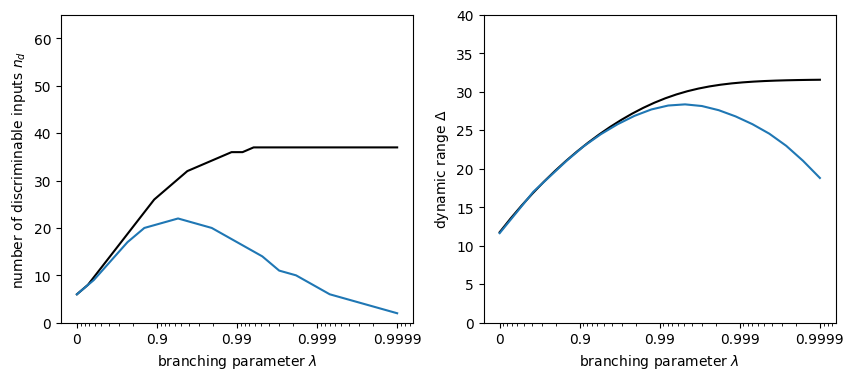

In [ ]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_inf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()